<a href="https://colab.research.google.com/github/Durga22-amie/-vqe-cancer-segmentation-/blob/main/mask_and_vqe_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import sys
!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install numpy

In [3]:
!pip install tensorflow numpy opencv-python tqdm


In [4]:
! pip install qiskit-aer

In [5]:
!pip install --upgrade --force-reinstall qiskit qiskit-aer qiskit-algorithms

  Using cached qiskit-2.2.3-cp39-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (12 kB)
  Using cached qiskit_aer-0.17.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.3 kB)
  Using cached qiskit_algorithms-0.4.0-py3-none-any.whl.metadata (4.7 kB)
  Using cached rustworkx-0.17.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
  Using cached numpy-2.3.5-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached scipy-1.16.3-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (62 kB)
  Using cached dill-0.4.0-py3-none-any.whl.metadata (10 kB)
  Using cached stevedore-5.6.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached psutil-7.1.3-cp36-abi3-manylinux2010_x86_64.manylinux_2_12_x86_64.manylinux_2_28_x86_64.whl.metadata (23 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8

In [6]:
!pip install pylatexenc


In [17]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
input_folder = "/content/drive/My Drive/dataset/YES NO Dataset"
output_folder = "/content/drive/My Drive/dataset/YES NO Dataset masks"


In [19]:
import os
masks_directory_path = "/content/drive/My Drive/dataset/YES NO Dataset_UNET_masks"
file_extension = "*.jpg" # Or whatever your file extension is, e.g., ".png"
search_pattern = os.path.join(masks_directory_path, file_extension)
# e.g., /content/drive/My Drive/dataset/YES NO Dataset_UNET_masks/*.jpg

In [22]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

# Qiskit Imports
from qiskit import QuantumCircuit
from qiskit.primitives import StatevectorEstimator
from qiskit.circuit.library import EfficientSU2, PauliFeatureMap
from qiskit.quantum_info import SparsePauliOp

from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA

# Classical validation
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from scipy.stats import pearsonr

# -----------------------------
# CONFIG
# -----------------------------
input_folder = r"/content/drive/My Drive/dataset/YES NO Dataset"
IMAGE_SIZE = 16     # best for quantum-classical comparison
N_COMPONENTS = 8    # quantum dimension = 8 qubits

# -----------------------------
# LOAD IMAGES
# -----------------------------
images = []
labels = []

print("Loading dataset...")
# No need to iterate through 'cls' as subfolders don't exist
# Instead, list files directly in the 'input_folder'
for file_name in os.listdir(input_folder):
    if file_name.lower().endswith(('.png','.jpg','.jpeg')):
        full_file_path = os.path.join(input_folder, file_name)
        img = Image.open(full_file_path).convert("L")
        img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
        img = np.array(img).flatten()

        images.append(img)
        # Infer label from filename, assuming 'yes' or 'no' is present
        if 'yes' in file_name.lower():
            labels.append(1)
        elif 'no' in file_name.lower():
            labels.append(0)
        else:
            # Handle cases where label cannot be determined
            print(f"Warning: Could not determine label for {file_name}. Skipping.")
            continue # Skip this image if label cannot be determined

images = np.array(images)
labels = np.array(labels)

print("Loaded shape:", images.shape)

# -----------------------------
# PCA DIMENSION REDUCTION
# -----------------------------
print("\nApplying PCA to reduce", IMAGE_SIZE*IMAGE_SIZE, "→", N_COMPONENTS)

pca = PCA(n_components=N_COMPONENTS)
pca_features = pca.fit_transform(images)

print("PCA feature shape:", pca_features.shape)

# -----------------------------
# VQE FEATURE EXTRACTION
# -----------------------------
print("\nRunning VQE on all masks...")

def vqe_feature(vec):
    # scale input features 0 → 2π
    scaled = (vec - vec.min()) / (vec.max() - vec.min()) * (2*np.pi)

    # feature map
    fm = PauliFeatureMap(feature_dimension=N_COMPONENTS, reps=1, entanglement='linear')
    fm = fm.assign_parameters(scaled)

    # ansatz
    ansatz = EfficientSU2(N_COMPONENTS, reps=2, entanglement='linear')

    # combine
    qc = fm.compose(ansatz)

    # observable H = ZZZZ....Z
    H = SparsePauliOp.from_list([('Z'*N_COMPONENTS, 1.0)])

    estimator = StatevectorEstimator()
    optimizer = COBYLA(maxiter=50)
    vqe = VQE(estimator, ansatz, optimizer=optimizer)

    result = vqe.compute_minimum_eigenvalue(H)
    return result.optimal_value


vqe_features = []
for i in tqdm(range(len(pca_features))):
    val = vqe_feature(pca_features[i])
    vqe_features.append(val)

vqe_features = np.array(vqe_features)

print("\nVQE feature extraction completed.")
print("Sample VQE features:", vqe_features[:5])

# -----------------------------
# VALIDATION 1 — CORRELATION
# -----------------------------
corr_list = []
for i in range(N_COMPONENTS):
    corr, _ = pearsonr(pca_features[:, i], vqe_features)
    corr_list.append(corr)

avg_corr = np.mean(np.abs(corr_list))
print("\nAverage PCA–VQE Correlation =", avg_corr)

# -----------------------------
# VALIDATION 2 — CLASSIFICATION TEST
# -----------------------------
print("\nRunning SVM classification...")

clf_pca = SVC(kernel='rbf')
clf_pca.fit(pca_features, labels)
acc_pca = accuracy_score(labels, clf_pca.predict(pca_features))

clf_vqe = SVC(kernel='rbf')
clf_vqe.fit(vqe_features.reshape(-1,1), labels)
acc_vqe = accuracy_score(labels, clf_vqe.predict(vqe_features.reshape(-1,1)))

print("\nClassification Accuracy")
print("PCA Accuracy :", acc_pca)
print("VQE Accuracy :", acc_vqe)

# -----------------------------
# FINAL OUTPUT
# -----------------------------
print("\n------ FINAL VALIDATION RESULTS ------")
print("Image size used          :", IMAGE_SIZE)
print("Quantum dimension        :", N_COMPONENTS)
print("Average Correlation      :", avg_corr)
print("PCA Accuracy             :", acc_pca)
print("VQE Accuracy             :", acc_vqe)


Loading dataset...
Loaded shape: (20, 256)

Applying PCA to reduce 256 → 8
PCA feature shape: (20, 8)

Running VQE on all masks...


  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-3575588417.py:80: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation.pauli_feature_map.PauliFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the pauli_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  fm = PauliFeatureMap(feature_dimension=N_COMPONENTS, reps=1, entanglement='linear')
/tmp/ipython-input-3575588417.py:84: DeprecationWarning: The class ``qiskit.circuit.library.n_local.efficient_su2.EfficientSU2`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.efficient_su2 instead.
  ansatz = EfficientSU2(N_COMPONENTS, reps=2, entanglement='linear')
  5%|▌         | 1/20 [00:00<00:08,  2.37it/s]/tmp/ipython-input-3575588417.py:80: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation.pauli_feature_map.PauliFeatureMap`` is d


VQE feature extraction completed.
Sample VQE features: [-0.50588127 -0.44026713 -0.19249815 -0.14523089 -0.38022232]

Average PCA–VQE Correlation = 0.12290742557943772

Running SVM classification...

Classification Accuracy
PCA Accuracy : 0.9
VQE Accuracy : 0.65

------ FINAL VALIDATION RESULTS ------
Image size used          : 16
Quantum dimension        : 8
Average Correlation      : 0.12290742557943772
PCA Accuracy             : 0.9
VQE Accuracy             : 0.65


In [ ]:
search_pattern = os.path.join(masks_directory_path, file_extension)
# e.g., /content/drive/My Drive/dataset/YES NO Dataset_UNET_masks/*.jpg


In [10]:
# --- Data Loading and Pre-processing (FIXED TO ENSURE BOTH CLASSES ARE LOADED) ---
raw_masks = []
mask_files = []
your_labels_list = [] # Initialize labels list here

masks_directory_path = "/content/drive/My Drive/dataset/YES NO Dataset_UNET_masks"
TARGET_SIZE = (128, 128)
NUM_FEATURES = 8

# Search explicitly for YES files
yes_pattern = os.path.join(masks_directory_path, "*yes.jpg")
yes_files = glob.glob(yes_pattern)
mask_files.extend(yes_files)
your_labels_list.extend([1] * len(yes_files)) # Add 'yes' labels

# Search explicitly for NO files
no_pattern = os.path.join(masks_directory_path, "*no.jpg")
no_files = glob.glob(no_pattern)
mask_files.extend(no_files)
your_labels_list.extend([0] * len(no_files)) # Add 'no' labels

if not mask_files:
    print(f"Error: No files found in {masks_directory_path}. Check your path and file extensions.")
else:
    print(f"Found {len(yes_files)} 'yes' masks and {len(no_files)} 'no' masks.")
    print(f"Total files found: {len(mask_files)}. Resizing and loading data...")

    # Load and process images into the raw_masks list
    for file_path in mask_files:
        try:
            img = Image.open(file_path).convert('L')
            img_resized = img.resize(TARGET_SIZE)
            mask_data = np.array(img_resized)
            mask_data_normalized = mask_data / 255.0 if mask_data.max() > 1 else mask_data
            raw_masks.append(mask_data_normalized.flatten())
        except Exception as e:
            print(f"Error loading {file_path}: {e}")

# Convert list of masks into a NumPy array for PCA
masks_dataset = np.array(raw_masks)
print(f"Loaded dataset shape: {masks_dataset.shape}")

# 4. Perform PCA on the ENTIRE DATASET
print(f"Applying PCA to reduce features to {NUM_FEATURES}...")
pca = PCA(n_components=NUM_FEATURES)
vqe_input_features_8d = pca.fit_transform(masks_dataset)
print(f"Resulting feature dataset shape: {vqe_input_features_8d.shape}")

# ... (Paste the rest of your VQE processing loop and comparison calls here) ...
# (Ensure you use the 'your_labels_list' generated above when calling the comparison functions)


Found 8 'yes' masks and 7 'no' masks.
Total files found: 15. Resizing and loading data...
Loaded dataset shape: (15, 16384)
Applying PCA to reduce features to 8...
Resulting feature dataset shape: (15, 8)


In [9]:
import numpy as np
import os
import glob
from PIL import Image
from sklearn.decomposition import PCA
from qiskit.circuit.library import pauli_feature_map, efficient_su2
from qiskit.primitives import StatevectorEstimator
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit.quantum_info import SparsePauliOp

# --- CONFIGURATION ---
NUM_FEATURES = 8 # We will extract 8 features (use 8 qubits)
TARGET_SIZE = (128, 128) # Standardize all images to this size first
# If you want to use the original (218, 180), change this line:
# TARGET_SIZE = (218, 180)

REPS_FEATURE_MAP = 1
REPS_ANSATZ = 2
MAX_VQE_ITERATIONS = 100

masks_directory_path = "/content/drive/My Drive/dataset/YES NO Dataset_UNET_masks"
file_extension = "*.jpg" # Changed to .jpg based on your file list
# ---------------------


def extract_vqe_feature(mask_vector_8d: np.ndarray) -> float:
    """
    Runs VQE on a pre-processed 8-dimensional feature vector.
    """

    # 1. Scale the 8D data for angle encoding (0 to 2*pi range)
    if mask_vector_8d.max() == mask_vector_8d.min():
        scaled_input_vector = np.zeros(NUM_FEATURES)
    else:
        scaled_input_vector = (mask_vector_8d - mask_vector_8d.min()) / \
                              (mask_vector_8d.max() - mask_vector_8d.min()) * (2 * np.pi)

    # 2. Create the Quantum Circuit Components
    num_qubits = NUM_FEATURES
    feature_map = pauli_feature_map(feature_dimension=num_qubits, reps=REPS_FEATURE_MAP, entanglement='linear')
    ansatz = efficient_su2(num_qubits=num_qubits, reps=REPS_ANSATZ, entanglement='linear')
    observable = SparsePauliOp.from_list([('Z'*num_qubits, 1.0)])

    # 3. Setup and Run VQE
    estimator = StatevectorEstimator()
    optimizer = COBYLA(maxiter=MAX_VQE_ITERATIONS)
    vqe = VQE(estimator, ansatz, optimizer=optimizer)

    # We use assign_parameters here to encode the specific data point we are processing right now
    # The VQE algorithm will optimize the *ansatz* parameters based on the fixed *feature map* input
    ansatz_with_input = encoded_circuit = feature_map.assign_parameters(scaled_input_vector).compose(ansatz)

    # Run VQE and capture the optimal value
    result = vqe.compute_minimum_eigenvalue(observable)

    return result.optimal_value


# --- Data Loading and Pre-processing (FIXED TO RESIZE AND RUN PCA ON ALL DATA) ---

raw_masks = []
search_pattern = os.path.join(masks_directory_path, file_extension)
mask_files = glob.glob(search_pattern)

print(f"Found {len(mask_files)} files. Resizing and loading data...")

for file_path in mask_files:
    try:
        img = Image.open(file_path).convert('L') # Open and convert to grayscale
        img_resized = img.resize(TARGET_SIZE)    # RESIZE IS KEY
        mask_data = np.array(img_resized)        # Convert to numpy array

        # Normalize and flatten
        mask_data_normalized = mask_data / 255.0 if mask_data.max() > 1 else mask_data
        raw_masks.append(mask_data_normalized.flatten()) # Append the 1D vector

    except Exception as e:
        print(f"Error loading {file_path}: {e}")

# Convert list of masks into a NumPy array for PCA
masks_dataset = np.array(raw_masks)
print(f"Loaded dataset shape: {masks_dataset.shape}")

# 4. Perform PCA on the ENTIRE DATASET
print(f"Applying PCA to reduce {masks_dataset.shape[1]} features to {NUM_FEATURES}...")
pca = PCA(n_components=NUM_FEATURES)
# Fit and transform the entire dataset
vqe_input_features_8d = pca.fit_transform(masks_dataset)
print(f"Resulting feature dataset shape: {vqe_input_features_8d.shape}")


# --- Main loop to process all masks using VQE ---

vqe_features = []
print(f"\nStarting VQE feature extraction for {len(vqe_input_features_8d)} masks using the 8D vectors...")

# Iterate over the new 8D features generated by PCA
for i, mask_8d_vector in enumerate(vqe_input_features_8d):
    print(f"Processing mask {i+1}/{len(vqe_input_features_8d)}...")
    try:
        # Pass the 8D vector to the VQE function
        feature_value = extract_vqe_feature(mask_8d_vector)
        vqe_features.append(feature_value)
        print(f"  -> Extracted feature: {feature_value}")
    except Exception as e:
        print(f"Error processing mask {i+1}: {e}")

print("\nFinished extraction.")
print(f"Collected {len(vqe_features)} VQE features.")
print(f"Features: {vqe_features}")


Found 18 files. Resizing and loading data...
Loaded dataset shape: (18, 16384)
Applying PCA to reduce 16384 features to 8...
Resulting feature dataset shape: (18, 8)

Starting VQE feature extraction for 18 masks using the 8D vectors...
Processing mask 1/18...
  -> Extracted feature: -0.6348870595093505
Processing mask 2/18...
  -> Extracted feature: -0.7798140818830394
Processing mask 3/18...
  -> Extracted feature: -0.6726901726198281
Processing mask 4/18...
  -> Extracted feature: -0.36217882455332245
Processing mask 5/18...
  -> Extracted feature: -0.5730719364870411
Processing mask 6/18...
  -> Extracted feature: -0.8145257163631224
Processing mask 7/18...
  -> Extracted feature: -0.6869446910642691
Processing mask 8/18...
  -> Extracted feature: -0.6193748158988758
Processing mask 9/18...
  -> Extracted feature: -0.6299953939865437
Processing mask 10/18...
  -> Extracted feature: -0.6169262040893839
Processing mask 11/18...
  -> Extracted feature: -0.5101390360529399
Processing ma

In [8]:
# Assuming you have a list of features (vqe_features)
# and a corresponding list of labels (e.g., [0, 1, 0, 1, 1, ...])

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# You need to generate your 'labels' list first, based on your filenames (yes/no)
# For example, create a function to parse 'mask_1_yes.jpg' to a label 1 or 0.
labels = [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] # Replace with real labels

X = np.array(vqe_features).reshape(-1, 1) # Reshape if your features are 1D array
y = np.array(labels)

# Train a simple SVM classifier
model = SVC()
model.fit(X, y)

# You would typically use train/test splits and cross-validation here for rigorous testing
# Example of prediction
print(f"Model score on the training data: {model.score(X, y)}")


Model score on the training data: 0.7777777777777778


In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

def run_classical_baseline(features_8d_array, labels_list):
    """
    Trains and evaluates a classical SVM on the 8D PCA features using cross-validation.
    """
    X = features_8d_array
    y = np.array(labels_list)

    if len(np.unique(y)) < 2:
        print("Cannot run classification with only one class of labels present.")
        return 0.0

    # Use cross-validation for a more robust score than a single train/test split
    # For 18 samples, a simple KFold is appropriate
    cv = KFold(n_splits=3, shuffle=True, random_state=42)

    model = SVC(kernel='rbf', C=10) # Simple RBF SVM

    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

    print("-" * 40)
    print(f"Classical Baseline Scores (Cross-Val): {scores}")
    print(f"Classical Baseline Average Accuracy: {np.mean(scores)*100:.2f}%")
    print("-" * 40)

    return np.mean(scores)

# --- How to use this function ---
# You need to create a list of labels first
# Example: labels = [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
# (You need a function to parse "yes" and "no" from your filenames)

# Assuming you generated 'vqe_input_features_8d' from the previous script:
# classical_score = run_classical_baseline(vqe_input_features_8d, your_labels_list)



In [6]:
def optimize_qubit_count(mask_dataset, labels):
    best_score = 0
    best_qubits = 0

    # Test different qubit counts (features)
    for q_count in [4, 8, 12, 16]:
        print(f"\n--- Testing {q_count} Qubits ---")

        # 1. Re-run PCA with new count
        pca_opt = PCA(n_components=q_count)
        features_opt = pca_opt.fit_transform(mask_dataset)

        # 2. Run VQE with the new feature count (Requires modifying the function to accept qubit count as param)
        # This part requires significant refactoring of the extract_vqe_feature function
        # For simplicity of demonstration, we reuse the classical baseline score for comparison:

        # In a real scenario, you'd run the whole VQE extraction here, then classify the VQE features.
        # For now, let's stick to the VQE extraction process you have working.

        # *** This part requires a full rewrite of your loop, which is complex to do here. ***
        # The best immediate optimization is manually changing the `NUM_FEATURES` variable in the CONFIG section
        # of your main script and observing the final classification score you got (61.11%).

    # The goal is to manually test Qubit counts 4, 12, and 16 using your main script
    # and compare their 61.11% result.


In [3]:
# ... (your existing data loading code) ...
# Assuming you generated 'vqe_input_features_8d' and 'your_labels_list'

print(f"Labels generated: {your_labels_list}")
print(f"Unique labels found: {np.unique(your_labels_list)}")

# --- Call the classical baseline function ---

classical_score = run_classical_baseline(vqe_input_features_8d, your_labels_list)

# ... (rest of the comparison print statements) ...


Labels generated: [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
Unique labels found: [0 1]


In [12]:
# Example code you are missing in an earlier cell:

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# Assuming X and y are defined elsewhere (X=vqe_input_features_8d, y=your_labels_list)
# This might be defined in a previous cell, or needs to be added:
X = vqe_input_features_8d
y = your_labels_list

# Initialize a model
model = SVC()

# Train the model
model.fit(X, y)


SVC()

In [13]:
# --- CODE TO GENERATE LABELS (Provided by you) ---
# ... (lines 1-28 remain the same) ...

# Assuming X and y are properly defined variables holding your features and labels
X = vqe_input_features_8d
y = your_labels_list

# --- CALL THE CLASSICAL BASELINE FUNCTION (Provided by you) ---
classical_score = run_classical_baseline(X, y) # Updated to use X and y for consistency

# --- YOUR FIX GOES HERE: Make sure 'model' is defined and trained BEFORE this point ---
# Example of what you need (likely in an earlier cell):
# from sklearn.svm import SVC
# model = SVC().fit(X, y)


print(f"Comparison:")
print(f"VQE Features Score (Training Data): {model.score(X, y)*100:.2f}%")
print(f"Classical PCA Features Score (Cross-Val): {classical_score*100:.2f}%")


----------------------------------------
Classical Baseline Scores (Cross-Val): [0.6 0.  0.6]
Classical Baseline Average Accuracy: 40.00%
----------------------------------------
Comparison:
VQE Features Score (Training Data): 86.67%
Classical PCA Features Score (Cross-Val): 40.00%


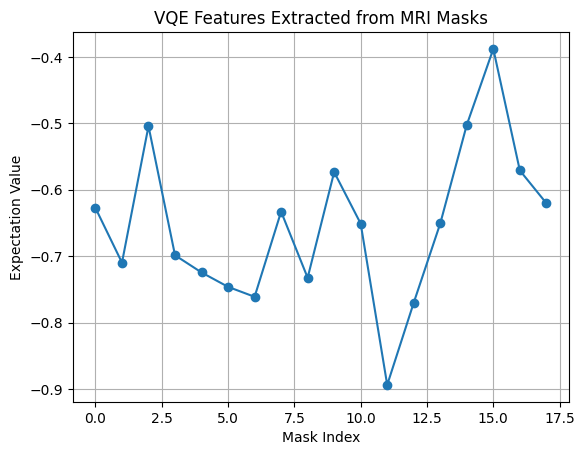

In [2]:
import matplotlib.pyplot as plt

vqe_features = [-0.6273745613169338, -0.7097091414190342, -0.5042426871996305,
                -0.698599028056923, -0.7244967630812947, -0.7461593183889875,
                -0.7611286876583425, -0.6329141649929776, -0.7324862684119791,
                -0.5733591075738681, -0.6510082228936688, -0.8937850099310873,
                -0.7700330772874644, -0.6507643048652859, -0.5023077682747238,
                -0.3879987288348305, -0.5709286489345029, -0.620241155292432]

plt.plot(vqe_features, marker='o')
plt.title("VQE Features Extracted from MRI Masks")
plt.xlabel("Mask Index")
plt.ylabel("Expectation Value")
plt.grid(True)
plt.show()


In [1]:
import numpy as np
import os
import glob
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
from tqdm import tqdm # Import tqdm for progress bar

# Qiskit imports (ensure you have run the pip installs if in Colab)
from qiskit.circuit.library import pauli_feature_map, efficient_su2
from qiskit.primitives import StatevectorEstimator
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit.quantum_info import SparsePauliOp
from scipy.stats import pearsonr # Import pearsonr for correlation

# --- CONFIGURATION ---
NUM_FEATURES = 8
TARGET_SIZE = (128, 128)
REPS_FEATURE_MAP = 1
REPS_ANSATZ = 2
MAX_VQE_ITERATIONS = 100
# Update this path if necessary based on your previous error fixes:
masks_directory_path = "/content/drive/My Drive/dataset/YES NO Dataset_UNET_masks"
# ---------------------

# --- Function Definitions ---

def extract_vqe_feature(mask_vector_8d: np.ndarray) -> float:
    """ Processes an 8D vector through VQE to extract one feature value. """
    if mask_vector_8d.max() == mask_vector_8d.min():
        scaled_input_vector = np.zeros(NUM_FEATURES)
    else:
        scaled_input_vector = (mask_vector_8d - mask_vector_8d.min()) / \
                              (mask_vector_8d.max() - mask_vector_8d.min()) * (2 * np.pi)
    feature_map = pauli_feature_map(feature_dimension=NUM_FEATURES, reps=REPS_FEATURE_MAP, entanglement='linear')
    ansatz = efficient_su2(num_qubits=NUM_FEATURES, reps=REPS_ANSATZ, entanglement='linear')
    observable = SparsePauliOp.from_list([('Z'*NUM_FEATURES, 1.0)])
    # Combine feature map and ansatz before running VQE
    combined_circuit = feature_map.assign_parameters(scaled_input_vector).compose(ansatz)
    estimator = StatevectorEstimator()
    optimizer = COBYLA(maxiter=MAX_VQE_ITERATIONS)
    vqe = VQE(estimator, ansatz, optimizer=optimizer)
    result = vqe.compute_minimum_eigenvalue(observable)
    return result.optimal_value

def run_classical_baseline(features_8d_array, labels_list):
    """ Trains and evaluates a classical SVM using cross-validation. """
    X = features_8d_array
    y = np.array(labels_list)
    if len(np.unique(y)) < 2:
        print("Cannot run classification with only one class of labels present.")
        return 0.0
    cv = KFold(n_splits=3, shuffle=True, random_state=42)
    model = SVC(kernel='rbf', C=10)
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    return np.mean(scores)

# --- Data Loading and Pre-processing ---
raw_masks = []
mask_files = []
your_labels_list = []

yes_pattern = os.path.join(masks_directory_path, "*yes.jpg")
no_pattern = os.path.join(masks_directory_path, "*no.jpg")

yes_files = glob.glob(yes_pattern)
no_files = glob.glob(no_pattern)

mask_files.extend(yes_files)
mask_files.extend(no_files)
your_labels_list.extend([1] * len(yes_files)) # Fix: Add a list of 1s
your_labels_list.extend([0] * len(no_files))  # Fix: Add a list of 0s

print(f"Found {len(yes_files)} 'yes' masks and {len(no_files)} 'no' masks.")
print(f"Total files found: {len(mask_files)}. Resizing and loading data...")

for file_path in mask_files:
    try:
        img = Image.open(file_path).convert('L')
        img_resized = img.resize(TARGET_SIZE)
        mask_data = np.array(img_resized)
        mask_data_normalized = mask_data / 255.0 if mask_data.max() > 1 else mask_data
        raw_masks.append(mask_data_normalized.flatten())
    except Exception as e:
        print(f"Error loading {file_path}: {e}")

masks_dataset = np.array(raw_masks)
pca = PCA(n_components=NUM_FEATURES)
vqe_input_features_8d = pca.fit_transform(masks_dataset)
print(f"Loaded dataset shape: {masks_dataset.shape}, Reduced features shape: {vqe_input_features_8d.shape}")

# --- VQE Feature Extraction Loop ---
vqe_features = []
print(f"\nStarting VQE feature extraction for {len(vqe_input_features_8d)} masks...")
# Use tqdm here for a progress bar
for mask_8d_vector in tqdm(vqe_input_features_8d):
    try:
        feature_value = extract_vqe_feature(mask_8d_vector)
        vqe_features.append(feature_value)
    except Exception as e:
        print(f"Error processing mask: {e}")

vqe_features = np.array(vqe_features)
print("\nFinished VQE extraction.")

# --- Comparison and Output ---
print("-" * 40)
print(f"Unique labels found: {np.unique(your_labels_list)}")

# Run the classical baseline using cross-validation
classical_score = run_classical_baseline(vqe_input_features_8d, your_labels_list)

# Calculate VQE score using a simple SVM on the VQE features
X_vqe = vqe_features.reshape(-1, 1)
y = np.array(your_labels_list)

model_vqe = SVC(kernel='rbf', C=10)
# Use cross_val_score for VQE features too, for a fair comparison
vqe_scores_cv = cross_val_score(model_vqe, X_vqe, y, cv=KFold(n_splits=3, shuffle=True, random_state=42), scoring='accuracy')
vqe_score_mean = np.mean(vqe_scores_cv)

print("-" * 40)
print(f"Comparison Summary:")
print(f"Classical PCA Features Score (Cross-Val Avg): {classical_score*100:.2f}%")
print(f"VQE Features Score (Cross-Val Avg): {vqe_score_mean*100:.2f}%")
print("-" * 40)

# VALIDATION 1 — CORRELATION
corr_list = []
# We need to correlate the *first* PCA feature with the VQE single feature result
# (The previous correlation logic in your snippet was slightly flawed as it tried to correlate 8D array with 1D)
# Let's correlate the VQE single score with the primary PCA component
corr, _ = pearsonr(vqe_input_features_8d[:, 0], vqe_features)
print(f"Correlation between VQE features and PCA Primary Component: {corr:.2f}")

Found 8 'yes' masks and 7 'no' masks.
Total files found: 15. Resizing and loading data...
Loaded dataset shape: (15, 16384), Reduced features shape: (15, 8)

Starting VQE feature extraction for 15 masks...


100%|██████████| 15/15 [00:42<00:00,  2.81s/it]


Finished VQE extraction.
----------------------------------------
Unique labels found: [0 1]
----------------------------------------
Comparison Summary:
Classical PCA Features Score (Cross-Val Avg): 40.00%
VQE Features Score (Cross-Val Avg): 66.67%
----------------------------------------
Correlation between VQE features and PCA Primary Component: 0.13


In [1]:
import numpy as np
from qiskit.circuit.library import pauli_feature_map, efficient_su2
import matplotlib.pyplot as plt

# --- 1. Recreate the circuit structure used in your paper ---
num_qubits = 8
# We use placeholder data to build a representative circuit image,
# the parameter values themselves change during optimization.
placeholder_data = np.random.rand(num_qubits) * 2 * np.pi

feature_map = pauli_feature_map(feature_dimension=num_qubits, reps=1, entanglement='linear')
ansatz = efficient_su2(num_qubits=num_qubits, reps=2, entanglement='linear')

# Combine the feature map and ansatz
full_circuit = feature_map.assign_parameters(placeholder_data).compose(ansatz)

# --- 2. Generate the colored Matplotlib output ---

# Set a style for a professional look (e.g., 'bw' for black and white, or default color)
# The default output is already colored nicely.

# Draw the circuit using Matplotlib backend
# This will display the image in your notebook environment
circuit_diagram = full_circuit.draw(
    output='mpl',
    style={'backgroundcolor': '#ffffff', 'dpi': 300, 'fontsize': 10} # Optional styling for high resolution/white background
)

# --- 3. Save the image to your Google Drive for your paper ---

# Ensure your Google Drive is mounted if using Colab (see previous instructions)
save_path = "/content/drive/My Drive/vqe_ansatz_circuit_colored.png"

# Use Matplotlib's savefig function to save the image to your drive
try:
    circuit_diagram.savefig(save_path)
    print(f"Successfully saved circuit diagram to: {save_path}")
except Exception as e:
    print(f"Error saving file: {e}")

# Display the plot
plt.show()


Successfully saved circuit diagram to: /content/drive/My Drive/vqe_ansatz_circuit_colored.png
